# OpenCVでとことん画像処理 - 後半
このノートは **後半** のノートになります。後半では

- [空間フィルタリング(20分)](#spatial)
	- [平滑化](#smoothing)
		- [平均化フィルタ](#mean)
		- [加重平均化(ガウシアン)フィルタ](#weight_mean)
		- [メディアンフィルタ](#median)
	- [エッジ検出](#edge)
		- [Cannyアルゴリズムによるエッジ検出](#canny)
	- [鮮鋭化(アンシャープマスキング)](#sharpening)
	- [エッジを保存した平滑化](#edge_smoothing)
		- [バイラテラルフィルタ](#bilateral)
		- [ノンローカルミーンフィルタ](#non_local_mean)
- [二値化(10分)](#binarize)
	- [単純なしきい値処理](#threshold)
		- [バイナリ形式(TOZERO形式)](#binary)
		- [切り捨て形式](#trunc)
	- [複雑なしきい値処理](#complex_threshold)
		- [大津法による二値化](#otsu) 
- [領域処理(10分)](#area)
	- [領域分割](#area_separate)
        - [クロマキーによるマスク処理](#chromakey)
		- [ミーンシフト法](#mean_shift)
		- [grabcut法](#grabcut)
- [まとめ](#conclusion)
    
を扱います。

## モジュールのインポート

In [1]:
%reload_ext autoreload
%autoreload 2

# これを書くとjupyterでmatplotlibなどが出力する画像の解像度が上がる
# %config InlineBackend.figure_format = 'retina'

import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
sys.path.append("../")
import time

from utils.plot import compare_plot

print(cv2.__version__)
print(matplotlib.__version__)

3.4.1
2.1.2


In [2]:
from tqdm import tqdm_notebook as tqdm

<a id="basic"></a>
## 画像の読み込み

In [3]:
img = cv2.cvtColor(cv2.imread("../data/Lenna_flat.png"), cv2.COLOR_BGR2RGB)

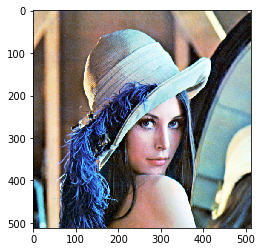

In [5]:
plt.imshow(img)

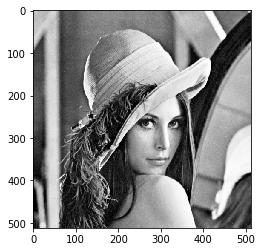

In [6]:
# 上のRGB画像をグレー画像にして読み込みます
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray")

<a id="spatial"></a>
## 空間フィルタリング
前半では画素ごとの濃淡変換を対応する**画素値**のみで行っていたが、画素値のみではなくその周辺の画素も含めた領域内の画素値を元に計算する。この処理を**空間フィルタリング**と呼び、そこで用いるフィルタは一般的に空間フィルタと呼ぶ。

<a id="smoothing"></a>
## 平滑化
画像になめらかな濃淡変換を与える処理を**平滑化**と呼んでおり、画像に含まれるノイズなどの不要な濃淡変動を軽減するときなどに用いられる。

<a id="mean"></a>
### 平均化フィルタ
画像をぼかすためにフィルタのサイズを元に平均をとったフィルタを用いて画像をぼかす手法を**平均化フィルタ**と呼ぶ。

<img src="../data/mean_filter.png" width=400>

### 手動でフィルタを定義する場合

In [23]:
# フィルタの定義
size = 5
kernel = np.ones((size,size),np.float32) / size**2

In [24]:
kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

In [25]:
img_mean_sm = cv2.filter2D(img, -1, kernel)

### 平均化フィルタを関数で実行する場合

In [37]:
img_blur = cv2.blur(img, (size, size))

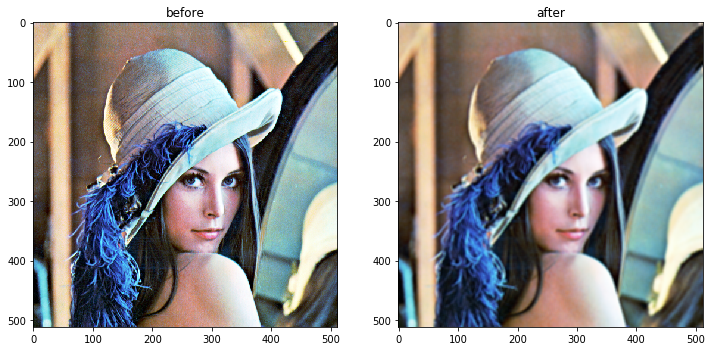

In [38]:
compare_plot([img, img_blur], ["before", "after"])

<a id="weight_mean"></a>
### 加重平均化(ガウシアンフィルタ)
単純なフィルターサイズに基づいた平均値ではなく、中央に近いほど大きな重みをつける**加重平均化フィルタ**というものもあります。その重みの中でも**ガウス分布(標準正規分布)**に近づけたものを**ガウシアンフィルタ**と呼ぶ。

標準正規分布を2次元(画像)に拡張した分布は以下のように表される。

$$ f(x) =  \frac{1}{ 2 \pi \sigma^2 } \exp \left( -  \frac{x^2 + y^2}{2 \sigma^2} \right) $$

<table border="0">
<tr>
<td><img src="../data/two_dim_gausian.png" width=300></td>
<td><img src="../data/weight_mean_filter.png" width=300></td>
</tr>
</table>

In [39]:
img_g_blur = cv2.GaussianBlur(img,(5,5),0)

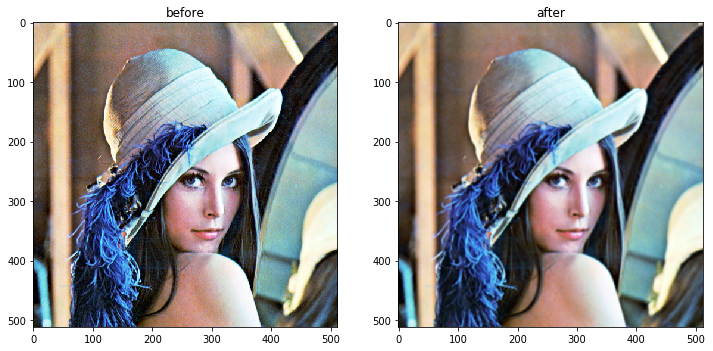

In [40]:
compare_plot([img, img_g_blur], ["before", "after"])

単純な平均化フィルタに比べて見た目にあまり大きな違いはありませんが、よりなめらかで自然な平滑化の効果を期待することができます。

<a id="median"></a>
### メディアンフィルタ
メディアンフィルタはフィルタサイズで指定された範囲の中の中央値を元の値と入れ替えるというもので、特にソルト・ペッパーノイズ(インパルスノイズ)の除去に強いと言われている手法です。

In [47]:
# 前半で作成したソルト・ペッパーノイズ画像を読み込む
img_sp = cv2.imread("../data/img_sp.png")

In [48]:
size = 5
img_blur = cv2.blur(img_sp, (size, size))
img_g_blur = cv2.GaussianBlur(img_sp, (size,size), 0)
img_m_blur = cv2.medianBlur(img_sp, size)

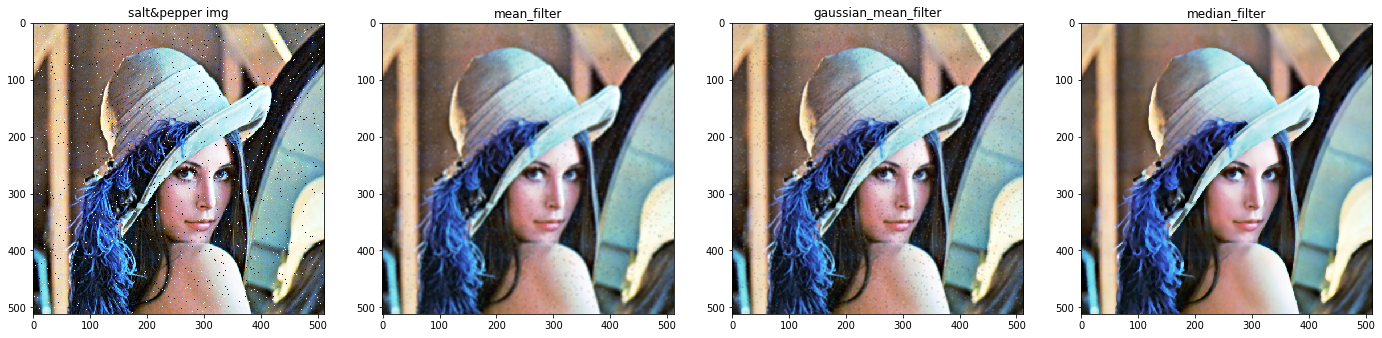

In [49]:
compare_plot([img_sp, img_blur, img_g_blur, img_m_blur], \
            ["salt&pepper img", "mean_filter", "gaussian_mean_filter", "median_filter"])

<a id="edge"></a>
## エッジ検出

<a id="canny"></a>
### Cannyアルゴリズムによるエッジ検出

<a id="sharpening"></a>
## 鮮鋭化

<a id="edge_smoothing"></a>
## エッジを保存した平滑化

<a id="birateral"></a>
### バイラテラルフィルタ

<a id="non_local_mean"></a>
### ノンローカルミーンフィルタ

<a id="binarize"></a>
## 2値化

<a id="threshold"></a>
## 単純なしきい値処理

<a id="binary"></a>
### バイナリ形式

<a id="trunc"></a>
### 切り捨て形式

<a id="complex_threshold"></a>
## 複雑なしきい値処理

<a id="otsu"></a>
### 大津法による2値化

<a id="area"></a>
## 領域処理

<a id="area_separate"></a>
## 領域分割

<a id="chromakey"></a>
### クロマキーによるマスク処理

<a id="mean_shift"></a>
### ミーンシフト法

<a id="grabcut"></a>
### grabcut法

<a id="conclusion"></a>
## まとめ

## 参考資料・サイト
+ ディジタル画像処理 改訂新版 5~章